In [12]:
import numpy as np
import pandas as pd
import sklearn
import re
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cross_validation
%matplotlib inline

In [13]:
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                             GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

In [16]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


# 特征提取

In [17]:
full_data = [train, test]

#先提取特征：是否有船舱？
train['Has_Cabin'] = train['Cabin'].apply(lambda x : 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x : 0 if type(x) == float else 1)

#姓名长度？
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

#再转化下性别特征？(1为男性，0为女性)
train['Sex'] = train['Sex'].map({'male':1, 'female': 0}).astype(int)

In [18]:
#再根据已有的条件，抽取特征：
for dataset in full_data:#计算家庭成员
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1#还要算上自己
for dataset in full_data:#是否一个人
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1,'IsAlone'] = 1 
for dataset in full_data: #处理登船口岸缺失值
    dataset['Embarked'].fillna('S',inplace = True) 
#处理船票缺失值（用的中位数）
for dataset in full_data:
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
#分段处理船票
train['CategoricalFare'] = pd.qcut(train['Fare'],4)
#填充年龄缺失值(这一步比较骚，用的一倍标准差填充)
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg-age_std, age_avg + age_std, size = age_null_count)
    dataset['Age'][dataset['Age'].isnull()] = age_null_random_list   
    dataset['Age'].astype('int', inplace = True)
train['CategoricalAge'] = pd.qcut(train['Age'], 5)   

In [19]:
#定义函数，提取每个乘客的称谓（有MR和Mrs之类的）
def get_title(name):
    title_search = re.search('\s([a-zA-Z]+)\.', name)#re.search.group（1）得到第一个括号圈出的部分。group(0返回所有部分)
    if title_search:
        return title_search.group(1)
    return ''
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
#把一些奇怪的title换成“Rare”
for dataset in full_data:
    dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],
                             'Rare', inplace = True)
    dataset['Title'].replace('Mlle', 'Miss', inplace = True)
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
#mapping title
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in full_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
#mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
#mapping fare
for dataset in full_data:
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 	= 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
#mapping age
for dataset in full_data:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 

# 特征选择

In [20]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [21]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,Name_length,FamilySize,IsAlone,Title
0,0,3,1,1.0,0,0,0,0,23,2,0,1
1,1,1,0,2.0,0,3,1,1,51,2,0,3
2,1,3,0,1.0,0,1,0,0,22,1,1,2
3,1,1,0,2.0,0,3,0,1,44,2,0,3
4,0,3,1,2.0,0,1,0,0,24,1,1,1


# 可视化

In [22]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,Name_length,FamilySize,IsAlone,Title
0,0,3,1,1.0,0,0,0,0,23,2,0,1
1,1,1,0,2.0,0,3,1,1,51,2,0,3
2,1,3,0,1.0,0,1,0,0,22,1,1,2
3,1,1,0,2.0,0,3,0,1,44,2,0,3
4,0,3,1,2.0,0,1,0,0,24,1,1,1


### pearson 相关系数

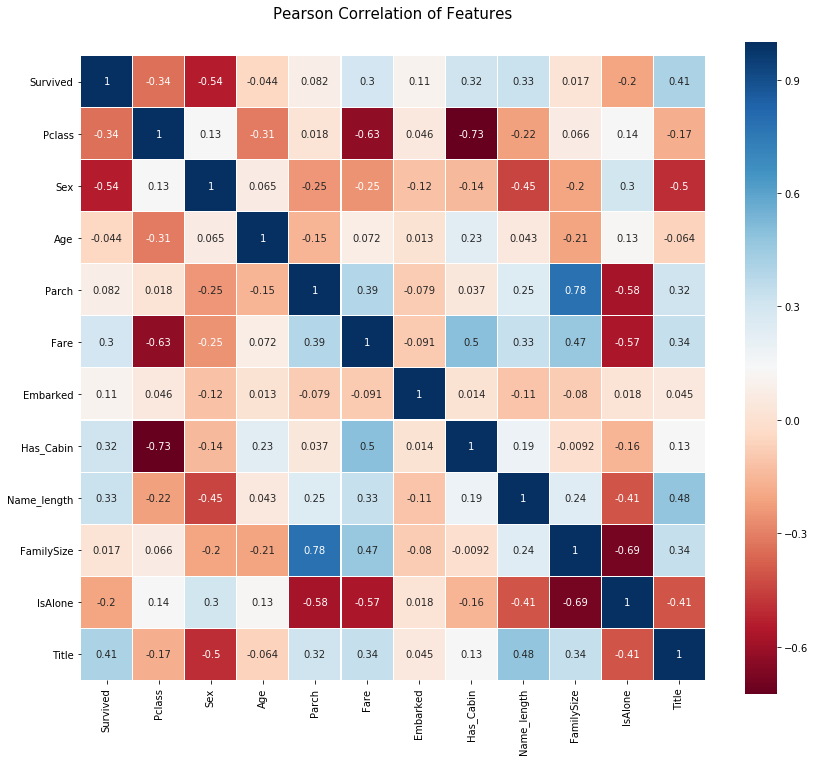

In [23]:
#热力图：让相关性看起来更明显
colormap = plt.cm.RdBu
plt.figure(figsize = (14,12))
plt.title('Pearson Correlation of Features', y = 1.05, size = 15)
sns.heatmap(train.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
            square = True, cmap = colormap, linecolor = 'white', annot = True)#linewidths表示的是每个格子的线宽；

### pariplot

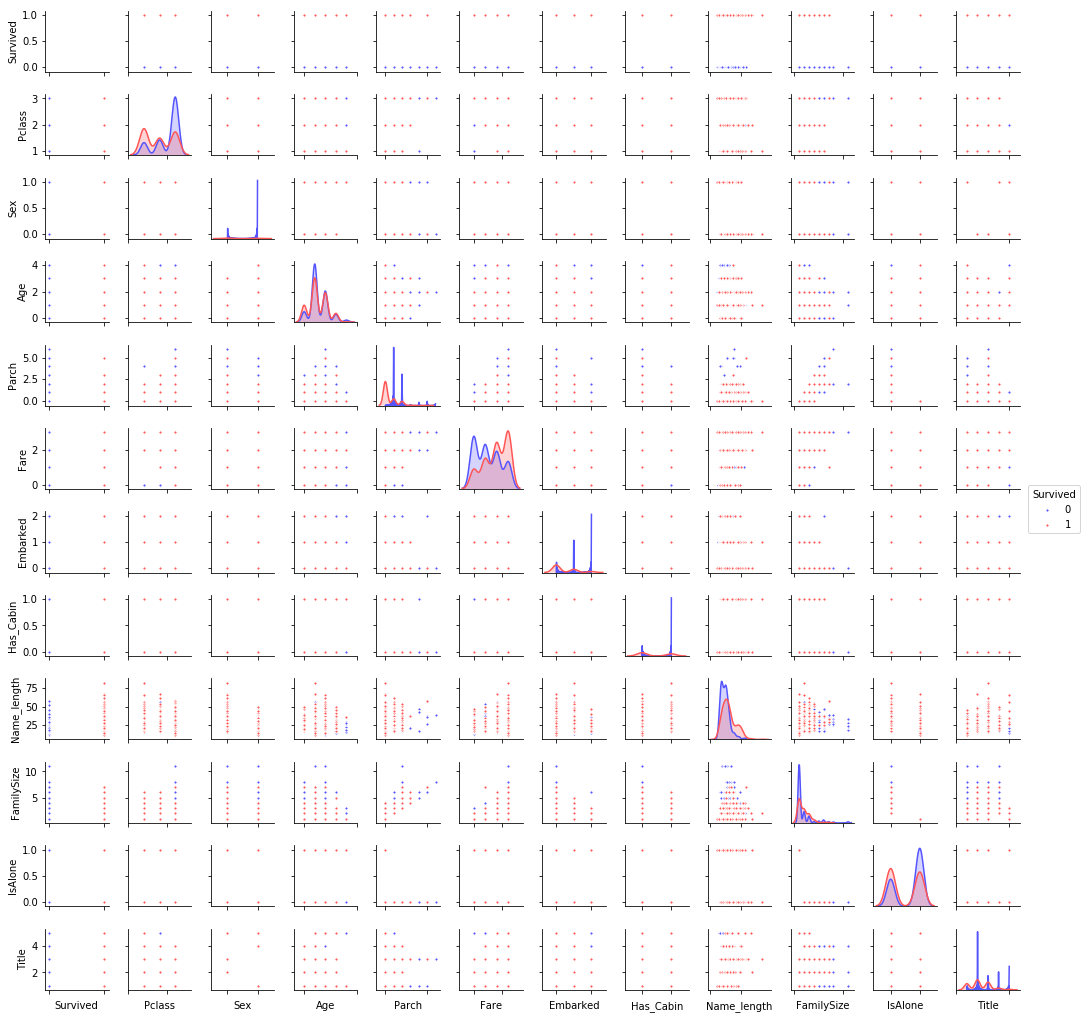

In [24]:
g = sns.pairplot(train, hue = 'Survived', palette = 'seismic', size = 1.2, diag_kind = 'kde',
                diag_kws = dict(shade = True), plot_kws = dict(s = 10))#palette是调色板颜色,diaf_kind有{hist, kde}两种选择
g.set(xticklabels = [])#把x轴的坐标给关了

从上面这一坨能看出的是：
* 除了age以外，其他变量在是否存活上的分布都有所不同
* 其他的我啥都看不出来

## 快乐建模

In [25]:
#作者为了调用方便，所以写了一个sklearnHelper类用来调用不同的sklearn模型。(我是不是应该抽个时间写一遍sklearn和sns)
class SklearnHelper(object):
    def __init__(self,clf, seed = 0, params = None):
        params['random_state'] = seed
        self.clf = clf(**params)
    
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importance(self, x, y):
        print(self.clf,fit(x, y).feature_importance_)
        
    def score(self, x_te, y_te):
        print (self.clf.fit.score(x_te, y_te))

In [26]:
#接下来定义不同模型的参数：
#随机森林
rf_params = {
    'n_jobs' : -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0    
}

#极度随机森林（ET）——这个不太清楚，有时间会再看下算法
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters（这个又是什么玩意儿？？）
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025 
}

In [27]:
SEED = 1

# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [30]:
#接下来要创建一个sklearn可以接受的数据形式~
y_train = train['Survived'].ravel()#ravel和flatten一个玩意儿
train = train.drop(['Survived'], axis = 1)
x_train = train.values
x_test = test.values

In [31]:
#分割验证集
x_tr, x_te, y_tr, y_te = cross_validation.train_test_split(x_train, y_train, test_size = 0.2, random_state = 0)

In [ ]:
#开始训练：

In [48]:
fit = {};
for i in ['rf', 'et', 'ada', 'gb', 'svc']:
    fit[i + '_fit'] = eval(i).fit(x_tr, y_tr)#eval解析字符串，并将其作为变量名

In [51]:
score = {};
for i in ['rf', 'et', 'ada', 'gb', 'svc']:
    score[i+ '_score'] = fit[i+'_fit'].score(x_te,y_te)

In [52]:
score

{'ada_score': 0.8268156424581006,
 'et_score': 0.8156424581005587,
 'gb_score': 0.8212290502793296,
 'rf_score': 0.8212290502793296,
 'svc_score': 0.7821229050279329}

In [55]:
?np.concatenate